In [1]:
import torch
# Neural networks
import torch.nn as nn
# Optim for error calculation
import torch.optim as optim

from torchvision import utils
from torchvision import datasets
from torchvision import transforms

from PIL import Image
import urllib.request as request
from matplotlib import pyplot as plt
#torch.set_printoptions(edgeitems=2) #default 3
#torch.manual_seed(123)

# Building a model
---



Download the datasets

In [2]:
data_path = 'data/'
full_data_set = datasets.CIFAR10(data_path, train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

full_validation_set = datasets.CIFAR10(data_path, train=False, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

Files already downloaded and verified
Files already downloaded and verified


Data loader for load the data in a specific size

In [3]:
size = 4
dataloader = torch.utils.data.DataLoader(full_data_set, batch_size=size, shuffle=True, num_workers=2)

Iterator for the dataloader and show the labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane
dog
bird
cat


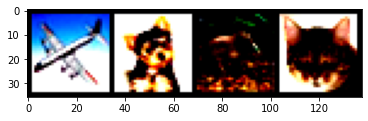

In [4]:
data_iterator = iter(dataloader)
imgs, labels = data_iterator.next()

classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

plt.imshow(utils.make_grid(imgs).permute(1, 2, 0))

for i in range(size):
  print(classes[labels[i]])

Select two labels and remaping the dataset for this labels

In [5]:
#classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
class_names = ['car', 'cat']

label_map = {1: 0, 3: 1}

data_set = [(img, label_map[label]) for img, label in full_data_set if label in [1, 3]]
validation_set = [(img, label_map[label]) for img, label in full_validation_set if label in [1, 3]]

validate the result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


'car'

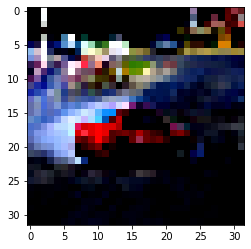

In [6]:
img, label = data_set[20]
print(img.shape)
plt.imshow(img.permute(1,2,0))
class_names[label]

Make a model, based in a linear tranformation, and then one activation function, in this case is a hyperbolic tangenth (Tanh) and then need a binary classificator 

In [7]:
model = nn.Sequential(
            # linear transformation with the same shape for each image, and a number of output of neurons
            nn.Linear(3 * 32 * 32, 512),
            nn.Tanh(),
            nn.Linear(512, 2))

Sigmoid function for classify the images

In [8]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

Example of sigmoid

In [9]:
x = torch.tensor([1.0, 2.0, 3.0])

print(sigmoid(x))
print(sigmoid(x).sum())

tensor([0.7311, 0.8808, 0.9526])
tensor(2.5644)


Softmax function for classify the images, softmax makes that the sum of all elements be 1

In [10]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

Example of softmax 

In [11]:
print(softmax(x))
print(softmax(x).sum())

tensor([0.0900, 0.2447, 0.6652])
tensor(1.)


Softmax function of torch

In [12]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

add softmax of torch in the model

In [13]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

send the image at the model adding the extra dimmension 

In [14]:
out = model(img.view(-1).unsqueeze(0))
out

tensor([[0.5511, 0.4489]], grad_fn=<SoftmaxBackward>)

Choose the max value of the result and print the prediction

In [15]:
_, index = torch.max(out, dim=1)

print('->',class_names[label],' model:',class_names[index])

-> car  model: car


# Implementing a fully conected classifier
---


The funcion softmax have limiting, and the logarithm for detect the error and the loss function use logarithm

In [16]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()

make new predicction with the new model and calculate the loss function 

In [17]:
img, label = data_set[20]

out = model(img.view(-1).unsqueeze(0))

_, index = torch.max(out, dim=1)

print('->',class_names[label],' model:',class_names[index])

loss(out, torch.tensor([label]))

-> car  model: cat


tensor(1.0120, grad_fn=<NllLossBackward>)

the model again

In [18]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning rate   
optimizer = calculation of gradients to minimize loss 
loss function    
n_epochs = number of iterations  
  
Do the training for calculate the loss 

In [19]:
learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

lossFunction = nn.NLLLoss()

n_epochs = 5 #100

for epoch in range(n_epochs):
    for img, label in data_set:
        out = model(img.view(-1).unsqueeze(0))
        # Calculate the loss 
        loss = lossFunction(out, torch.tensor([label]))
        # Delete the gradients
        optimizer.zero_grad()
        # Calculate the backpropagration
        loss.backward()
        # Make a step
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.186428
Epoch: 1, Loss: 0.005537
Epoch: 2, Loss: 0.001832
Epoch: 3, Loss: 0.002902
Epoch: 4, Loss: 0.022522


make a batch of data with the dataloader and remake all

In [20]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))


optimizer = optim.SGD(model.parameters(), lr=0.02)

loss_function = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.454013
Epoch: 1, Loss: 0.289849
Epoch: 2, Loss: 0.412891
Epoch: 3, Loss: 0.437282
Epoch: 4, Loss: 0.356043
Epoch: 5, Loss: 0.366293
Epoch: 6, Loss: 0.159915
Epoch: 7, Loss: 0.320515
Epoch: 8, Loss: 0.153856
Epoch: 9, Loss: 0.275233
Epoch: 10, Loss: 0.127672
Epoch: 11, Loss: 0.126610
Epoch: 12, Loss: 0.304140
Epoch: 13, Loss: 0.171542
Epoch: 14, Loss: 0.067280
Epoch: 15, Loss: 0.368931
Epoch: 16, Loss: 0.076892
Epoch: 17, Loss: 0.149984
Epoch: 18, Loss: 0.103590
Epoch: 19, Loss: 0.070709
Epoch: 20, Loss: 0.111766
Epoch: 21, Loss: 0.044447
Epoch: 22, Loss: 0.121764
Epoch: 23, Loss: 0.034495
Epoch: 24, Loss: 0.095357
Epoch: 25, Loss: 0.039176
Epoch: 26, Loss: 0.051550
Epoch: 27, Loss: 0.035900
Epoch: 28, Loss: 0.012918
Epoch: 29, Loss: 0.022050
Epoch: 30, Loss: 0.024052
Epoch: 31, Loss: 0.009364
Epoch: 32, Loss: 0.047873
Epoch: 33, Loss: 0.017902
Epoch: 34, Loss: 0.026431
Epoch: 35, Loss: 0.023921
Epoch: 36, Loss: 0.019081
Epoch: 37, Loss: 0.011194
Epoch: 38, Loss: 0.009

validate the accuracy of the model

In [21]:
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]

        correct += int((predicted == labels).sum())
      
print("Accuracy: %f" % (correct / total))

Accuracy: 0.868500


make one prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


->:  car  model: car


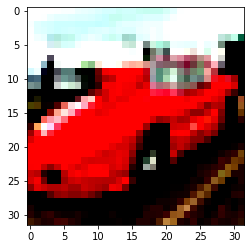

In [22]:
img, label = validation_set[20]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)

print('->: ',class_names[label],' model:',class_names[index])
plt.imshow(img.permute(1, 2, 0))
plt.show()

# Mejoras, limitaciones y conclusiones
---


softmax and logsoftmax = crossentropyloss  
lower the parameters of the model little by little  
calculate the loss of the model

In [23]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 0.01

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.400462
Epoch: 1, Loss: 0.355466
Epoch: 2, Loss: 0.685652
Epoch: 3, Loss: 0.343027
Epoch: 4, Loss: 0.495412
Epoch: 5, Loss: 0.630821
Epoch: 6, Loss: 0.281875
Epoch: 7, Loss: 0.242465
Epoch: 8, Loss: 0.225931
Epoch: 9, Loss: 0.187762
Epoch: 10, Loss: 0.337334
Epoch: 11, Loss: 0.348799
Epoch: 12, Loss: 0.582717
Epoch: 13, Loss: 0.139911
Epoch: 14, Loss: 0.290196
Epoch: 15, Loss: 0.226049
Epoch: 16, Loss: 0.080527
Epoch: 17, Loss: 0.219754
Epoch: 18, Loss: 0.063940
Epoch: 19, Loss: 0.074289
Epoch: 20, Loss: 0.340430
Epoch: 21, Loss: 0.056709
Epoch: 22, Loss: 0.106181
Epoch: 23, Loss: 0.030465
Epoch: 24, Loss: 0.044671
Epoch: 25, Loss: 0.040259
Epoch: 26, Loss: 0.075934
Epoch: 27, Loss: 0.101509
Epoch: 28, Loss: 0.010358
Epoch: 29, Loss: 0.033971
Epoch: 30, Loss: 0.030209
Epoch: 31, Loss: 0.011874
Epoch: 32, Loss: 0.031844
Epoch: 33, Loss: 0.796019
Epoch: 34, Loss: 0.008783
Epoch: 35, Loss: 0.019911
Epoch: 36, Loss: 0.003316
Epoch: 37, Loss: 0.005001
Epoch: 38, Loss: 0.005

Validate the accuracy of the model

In [24]:
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.860000


calculate the accuracy in the set of training  
is 1, that is bad, for the overfiting of the model

In [25]:
train_loader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 1.000000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct:  car  model: cat


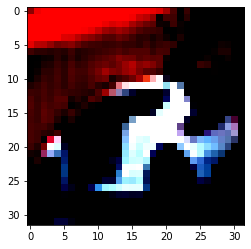

In [26]:
img, label = validation_set[1]
out = model(img.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)

print('correct: ',class_names[label],' model:',class_names[index])
plt.imshow(img.permute(1, 2, 0))

sum of the parameters or weights

In [27]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

make a prediction with a new image 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


correct: car   model: cat


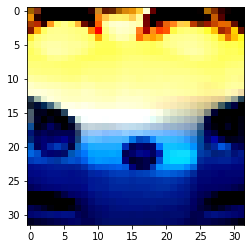

In [31]:
image = request.urlretrieve('https://i.pinimg.com/originals/43/bc/47/43bc47066bb8b2fa4fe7cc8e82cc3714.jpg','test,jpg')
                            
img = Image.open(image[0])

preprocess = transforms.Compose([
        transforms.Resize(48),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4915, 0.4823, 0.4468],
            std=[0.2470, 0.2435, 0.2616]
        )])

img_t = preprocess(img)
out = model(img_t.view(-1).unsqueeze(0))
_, index = torch.max(out, dim=1)
print('correct: car ',' model:',class_names[index])
plt.imshow(img_t.permute(1, 2, 0))